# Twitter Scraping

In [ ]:
 !pip install tweepy

In [1]:
import tweepy

In [3]:
consumer_key = ''
consumer_secret = ''

access_token = ''
access_secret = ''

In [149]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

## Scraping Modi's Tweets

In [27]:
modi_tweets = api.user_timeline('narendramodi', page=1, count=200)
len(modi_tweets)

200

In [11]:
modi_tweets[0].text

'I bow to His Holiness Dr. Sree Sree Sree Sivakumara Swamigalu on his Jayanti. \n\nHe lives in our hearts and minds.… https://t.co/T6CNMHIDjx'

In [12]:
modi_tweets[0].created_at

datetime.datetime(2019, 4, 1, 3, 28, 25)

In [20]:
modi_tweets[0].source

'Twitter for iPhone'

In [23]:
print(modi_tweets[0].geo)

None


In [21]:
modi_tweets[0].user.description

'Prime Minister of India'

In [24]:
modi_tweets[0].user.location

'India'

In [28]:
modi_tweets[0].favorite_count

5858

In [30]:
modi_tweets[0].retweet_count

1483

In [33]:
import pandas as pd
df_modi_tweets = pd.DataFrame()
for tweet in modi_tweets:
    curr_tweet = {
        'text': tweet.text,
        'likes': tweet.favorite_count,
        'retweets': tweet.retweet_count,
        'created_at': tweet.created_at,
        'source': tweet.source
    }
    df_modi_tweets = df_modi_tweets.append(curr_tweet,
                                          ignore_index=True)
#df_modi_tweets

In [81]:
df_modi_tweets = pd.DataFrame()
for page in range(1, 21):
    modi_tweets = api.user_timeline('narendramodi',
                                    page=page, count=200)
    for tweet in modi_tweets:
        curr_tweet = {
            'text': tweet.text,
            'likes': tweet.favorite_count,
            'retweets': tweet.retweet_count,
            'created_at': tweet.created_at,
            'source': tweet.source
        }
        df_modi_tweets = df_modi_tweets.append(curr_tweet,
                                              ignore_index=True)

In [38]:
df_modi_tweets.to_csv('narendramodi_tweets.csv', index=False, 
                     encoding='utf-8')

In [37]:
import os
os.getcwd() 

'/Users/skathirmani/Projects/manipal/ds-batch6'

## Twitter Analysis

In [39]:
df_modi_tweets['source'].value_counts()

Twitter Web Client      1633
Twitter Media Studio     741
Twitter for iPhone       535
Periscope                213
Twitter for Android       92
Twitter Ads Composer       1
Name: source, dtype: int64

In [43]:
df_modi_tweets.sort_values(by='likes', ascending=False).head(1)

,created_at,likes,retweets,source,text
357,2019-03-01 16:34:29,271910.0,66478.0,Twitter for iPhone,Welcome Home Wing Commander Abhinandan!\n\nThe...


In [82]:
df_modi_tweets['date'] = pd.to_datetime(
    df_modi_tweets['created_at'])
df_modi_tweets['date'].head()

0   2019-04-01 06:25:06
1   2019-04-01 03:28:25
2   2019-04-01 03:14:06
3   2019-04-01 03:11:17
4   2019-04-01 03:09:43
Name: date, dtype: datetime64[ns]

In [48]:
df_modi_tweets['date'].min(), df_modi_tweets['date'].max()

(Timestamp('2018-06-21 10:36:05'), Timestamp('2019-04-01 03:28:25'))

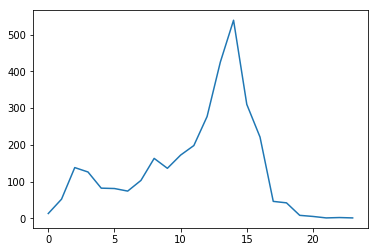

In [52]:
%matplotlib inline
df_modi_tweets['hour'] = df_modi_tweets['date'].dt.hour
df_modi_tweets['hour'].value_counts().sort_index().plot.line()

In [62]:
from pytz import timezone
#indian = pytz.timezone('Asia/Calcutta')
#df_modi_tweets['date'].apply(lambda v: indian.localize(v)).dt.hour.value_counts().sort_index().plot.line()

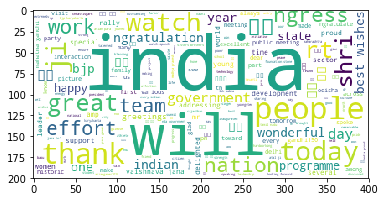

In [71]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
docs = df_modi_tweets['text'].str.lower()
docs = docs.str.replace('co','').str.replace('https','')
wc = WordCloud(background_color='white').generate(' '.join(docs))
plt.imshow(wc)

### Exercise: Identify frequency of each hashtag used by Modi
- Create a empty list called as `hashtags`
- Loop through each tweet
- Break tweet in to words by spliting string by space
- Identify if a word startswith `#`
- If so, append the word to `hashtags` list
- Convert list to Series and use `value_counts` to get frequency of each hastag
- Visualize top 10 hashtags using horizontal bar chart

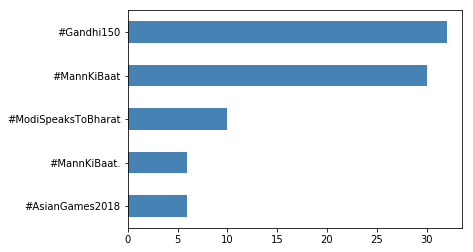

In [75]:
hashtags = []
for tweet in df_modi_tweets['text']:
    words = tweet.split(' ')
    tags = [word for word in words if word.startswith('#')]
    hashtags.extend(tags)
pd.Series(hashtags).value_counts().head()[::-1].plot.barh(
    color='steelblue')

### What is the frequency of a hashtag across month

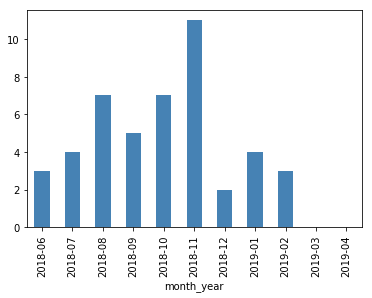

In [94]:
df_modi_tweets['month_year'] = df_modi_tweets['date'].dt.strftime(
    '%Y-%m')
    
df_modi_tweets['mannkibaat'] = df_modi_tweets['text'].apply(
    lambda text: 1 if '#MannKiBaat' in text else 0)
#df_modi_tweets[['month_year', 'mannkibaat']].head()

df_modi_tweets.groupby('month_year')['mannkibaat'].sum().plot.bar(
    color='steelblue')

In [95]:
df_modi_tweets['day'] = df_modi_tweets['date'].dt.day
df_modi_tweets['weekday'] = df_modi_tweets['date'].dt.strftime(
    '%A')
df_modi_tweets['hour'] = df_modi_tweets['date'].dt.hour


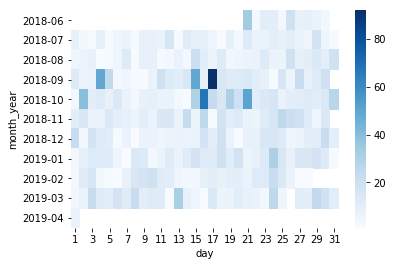

In [112]:
summary = df_modi_tweets.groupby(
    ['month_year', 'day']).size().reset_index()
summary = summary.rename(columns={0: 'count'})
summary_pivot = summary.pivot_table(index='month_year',
                                    columns='day',
                                    values='count')
import seaborn as sns
sns.heatmap(summary_pivot, cmap='Blues')

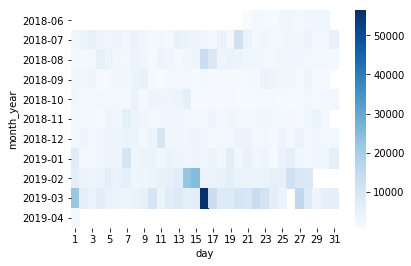

In [115]:
summary = df_modi_tweets.groupby(
    ['month_year', 'day'])['retweets'].mean().reset_index()
summary = summary.rename(columns={0: 'retweets'})
summary_pivot = summary.pivot_table(index='month_year',
                                    columns='day',
                                    values='retweets')
import seaborn as sns
sns.heatmap(summary_pivot, cmap='Blues')

## Twitter Scraping for a hashtag/Search Term

In [118]:
tweets = api.search('#ModiMatBanao', count=200)
len(tweets)

88

In [150]:
tweets_df = pd.DataFrame()

for tweet in tweepy.Cursor(api.search, '#ModiMatBanao').items():
    curr_tweet = {
        'display_name': tweet.user.name,
        'handler_name': tweet.user.screen_name,
        'text': tweet.text,
        'created_at': tweet.created_at,
        'followers': tweet.user.followers_count,
        'friends': tweet.user.friends_count,
        'user_description': tweet.user.description,
        'user_location': tweet.user.location,
        'likes': tweet.favorite_count,
        'retweets': tweet.retweet_count,

    }
    tweets_df = tweets_df.append(curr_tweet, ignore_index=True)
tweets_df.shape

KeyboardInterrupt: 